# COE379L Project 3: Transformer Model Fine-Tuning and Evaluation

## Cross-Model Comparison for News Topic Classification

This notebook covers:
- RoBERTa-base model fine-tuning
- Hugging Face Transformers integration
- Model evaluation and performance metrics
- Training time and inference latency measurement
- Comparison with classical models


## 1. Import Required Libraries


In [1]:
# Standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import os
warnings.filterwarnings('ignore')

# PyTorch
import torch

# Disable MPS (Metal Performance Shaders) to force CPU usage
# This prevents M1 GPU memory issues
if hasattr(torch.backends, 'mps'):
    torch.backends.mps.is_available = lambda: False
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '0'

from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# Hugging Face
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    TrainerCallback
)
from datasets import load_dataset

# Scikit-learn for metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    confusion_matrix,
    classification_report
)

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Check for GPU/device
# Using CPU for training to avoid M1 GPU memory issues and ensure stability
USE_CPU = True  # Set to False to use GPU if available (not recommended for M1)

# Force CPU usage
device = torch.device('cpu')
print(f"Using device: {device} (CPU - forced for stability)")
print(f"MPS available: {torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else 'N/A'}")
print(f"CUDA available: {torch.cuda.is_available()}")

print("\nLibraries imported successfully!")


Using device: cpu (CPU - forced for stability)
MPS available: False
CUDA available: False

Libraries imported successfully!


## 2. Load and Prepare Data


In [2]:
# Load AG News dataset from Hugging Face
print("=" * 80)
print("LOADING AG NEWS DATASET")
print("=" * 80)
print("Loading from Hugging Face...")
load_start = time.time()
dataset = load_dataset("ag_news")
load_time = time.time() - load_start
print(f"Dataset loaded in {load_time:.2f} seconds\n")

# Extract train and test splits
train_data_full = dataset['train']
test_data = dataset['test']

# Use subset of training data for faster training (< 1 hour target)
# Adjust TRAIN_SUBSET_SIZE to control training time
# Reduced to 1200 samples to guarantee < 1 hour training time on CPU
TRAIN_SUBSET_SIZE = 1200  # Use 1.2k samples for faster training (target: < 1 hour)
print(f"Full training samples: {len(train_data_full):,}")
print(f"Using subset: {TRAIN_SUBSET_SIZE:,} samples for faster training (< 1 hour target)")

# Create balanced subset (stratified sampling)
from sklearn.model_selection import train_test_split
import numpy as np

# Get labels for stratification
labels = [train_data_full[i]['label'] for i in range(len(train_data_full))]

# Create indices
indices = np.arange(len(train_data_full))

# Stratified split to get balanced subset
_, subset_indices = train_test_split(
    indices, 
    test_size=TRAIN_SUBSET_SIZE, 
    stratify=labels,
    random_state=42
)

# Select subset
train_data = train_data_full.select(subset_indices)

print(f"Training samples (subset): {len(train_data):,}")
print(f"Test samples: {len(test_data):,}")

# Class labels
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']
num_labels = len(class_labels)
print(f"Number of classes: {num_labels}")
print(f"Classes: {class_labels}")

# Show sample
print("\nSample data:")
print(train_data[0])


LOADING AG NEWS DATASET
Loading from Hugging Face...
Dataset loaded in 3.82 seconds

Full training samples: 120,000
Using subset: 1,200 samples for faster training (< 1 hour target)
Training samples (subset): 1,200
Test samples: 7,600
Number of classes: 4
Classes: ['World', 'Sports', 'Business', 'Sci/Tech']

Sample data:
{'text': 'Pixar Shares Jump to Record High on Results Shares of Pixar Animation Studios Inc. on Friday rose to a record high, a day after the company posted a 70 percent quarterly profit increase, driven by strong home video sales for  quot;Finding Nemo quot; and  quot;Monsters, Inc.', 'label': 2}


## 3. Initialize RoBERTa Tokenizer and Model


In [3]:
# Model name - using RoBERTa-base as specified in requirements
model_name = "roberta-base"

print("=" * 80)
print("INITIALIZING ROBERTA MODEL")
print("=" * 80)
print(f"Loading tokenizer and model: {model_name}")
print("This may take a moment (downloading if not cached)...\n")

# Load tokenizer
print("Loading tokenizer...")
tokenizer_start = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_time = time.time() - tokenizer_start
print(f"  Tokenizer loaded in {tokenizer_time:.2f} seconds")

# Load model for sequence classification
print("\nLoading model...")
model_start = time.time()
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)
model_load_time = time.time() - model_start
print(f"  Model loaded in {model_load_time:.2f} seconds ({model_load_time/60:.2f} minutes)")

# Move model to device (force CPU if USE_CPU is True)
if USE_CPU:
    device = torch.device('cpu')
    print(f"\nForcing CPU usage (USE_CPU=True)...")
else:
    print(f"\nMoving model to {device}...")
model = model.to(device)
print(f"  Model moved to {device}")
print(f"  Model device check: {next(model.parameters()).device}")

print(f"\n{'─'*80}")
print("MODEL INFORMATION")
print(f"{'─'*80}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Device: {device}")
print(f"USE_CPU flag: {USE_CPU}")
print("=" * 80 + "\n")

# Test tokenization
sample_text = train_data[0]['text']
print(f"\nSample text: {sample_text[:100]}...")
encoded = tokenizer(sample_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
print(f"Tokenized shape: {encoded['input_ids'].shape}")


INITIALIZING ROBERTA MODEL
Loading tokenizer and model: roberta-base
This may take a moment (downloading if not cached)...

Loading tokenizer...
  Tokenizer loaded in 0.84 seconds

Loading model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Model loaded in 0.32 seconds (0.01 minutes)

Forcing CPU usage (USE_CPU=True)...
  Model moved to cpu
  Model device check: cpu

────────────────────────────────────────────────────────────────────────────────
MODEL INFORMATION
────────────────────────────────────────────────────────────────────────────────
Model parameters: 124,648,708
Trainable parameters: 124,648,708
Device: cpu
USE_CPU flag: True


Sample text: Pixar Shares Jump to Record High on Results Shares of Pixar Animation Studios Inc. on Friday rose to...
Tokenized shape: torch.Size([1, 512])


## 4. Preprocess Dataset for Training


In [4]:
def tokenize_function(examples):
    """Tokenize the text data"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=512,  # RoBERTa max length
        return_tensors=None  # Return as lists, not tensors
    )

print("=" * 80)
print("TOKENIZING DATASETS")
print("=" * 80)
print(f"Training samples: {len(train_data):,}")
print(f"Test samples: {len(test_data):,}")
print("This may take a few minutes...\n")

print("Tokenizing training data...")
tokenize_start = time.time()
train_tokenized = train_data.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']  # Remove original text column
)
train_tokenize_time = time.time() - tokenize_start
print(f"  Training set tokenized in {train_tokenize_time:.2f} seconds ({train_tokenize_time/60:.2f} minutes)")

print("\nTokenizing test data...")
test_tokenize_start = time.time()
test_tokenized = test_data.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']
)
test_tokenize_time = time.time() - test_tokenize_start
print(f"  Test set tokenized in {test_tokenize_time:.2f} seconds ({test_tokenize_time/60:.2f} minutes)")

total_tokenize_time = time.time() - tokenize_start
print(f"\nTotal tokenization time: {total_tokenize_time:.2f} seconds ({total_tokenize_time/60:.2f} minutes)")
print("=" * 80 + "\n")

print(f"Tokenization complete!")
print(f"Training features: {train_tokenized.column_names}")
print(f"Test features: {test_tokenized.column_names}")

# Set format for PyTorch
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("Dataset formatted for PyTorch!")


TOKENIZING DATASETS
Training samples: 1,200
Test samples: 7,600
This may take a few minutes...

Tokenizing training data...


Map: 100%|██████████| 1200/1200 [00:00<00:00, 2602.72 examples/s]


  Training set tokenized in 0.55 seconds (0.01 minutes)

Tokenizing test data...
  Test set tokenized in 0.09 seconds (0.00 minutes)

Total tokenization time: 0.64 seconds (0.01 minutes)

Tokenization complete!
Training features: ['label', 'input_ids', 'attention_mask']
Test features: ['label', 'input_ids', 'attention_mask']
Dataset formatted for PyTorch!


## 5. Define Metrics Function


In [5]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro
    }

print("Metrics function defined!")


Metrics function defined!


## 6. Configure Training Arguments


In [6]:
# Training arguments optimized for fast training (< 1 hour target)
# Using subset of data (10k samples) and reduced epochs
training_args = TrainingArguments(
    output_dir='./roberta-ag-news',
    num_train_epochs=1,  # Reduced to 1 epoch for faster training
    per_device_train_batch_size=16,  # Larger batch for faster training
    per_device_eval_batch_size=32,  # Larger eval batch
    gradient_accumulation_steps=1,  # No accumulation needed with larger batch
    warmup_steps=100,  # Reduced warmup steps
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,  # More frequent logging
    eval_strategy="steps",  # Evaluate every N steps
    eval_steps=200,  # Evaluate more frequently (every 200 steps)
    save_strategy="steps",  # Must match eval_strategy when load_best_model_at_end=True
    save_steps=200,  # Save every 200 steps (matching eval_steps)
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,  # Keep only 2 best models
    fp16=False,  # Not needed on CPU
    dataloader_num_workers=0,  # Set to 0 for CPU
    report_to="none",  # Disable wandb/tensorboard
    logging_first_step=True,  # Log the first step
    prediction_loss_only=False,  # Show more metrics during evaluation
    dataloader_pin_memory=False,  # Not needed on CPU
)

# Calculate approximate total steps
num_train_samples = len(train_tokenized)
steps_per_epoch = num_train_samples // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args.num_train_epochs

print("Training arguments configured!")
print(f"Training epochs: {training_args.num_train_epochs}")
print(f"Batch size (train): {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation steps: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"Mixed precision (FP16): {training_args.fp16}")
print(f"Logging steps: {training_args.logging_steps}")
print(f"Evaluation steps: {training_args.eval_steps}")
print(f"Training samples: {num_train_samples:,}")
print(f"Approximate steps per epoch: {steps_per_epoch:,}")
print(f"Total training steps: ~{total_steps:,}")
print(f"\nEstimated training time: ~30-50 minutes (depending on CPU speed)")


Training arguments configured!
Training epochs: 1
Batch size (train): 16
Gradient accumulation steps: 1
Effective batch size: 16
Batch size (eval): 32
Mixed precision (FP16): False
Logging steps: 50
Evaluation steps: 200
Training samples: 1,200
Approximate steps per epoch: 75
Total training steps: ~75

Estimated training time: ~30-50 minutes (depending on CPU speed)


## 7. Create Trainer and Fine-Tune Model


In [7]:
# Create a custom callback for progress tracking
class ProgressCallback(TrainerCallback):
    """Custom callback to track and display training progress"""
    
    def __init__(self):
        self.start_time = None
        self.epoch_start_time = None
        self.last_log_time = None
        
    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()
        self.last_log_time = self.start_time
        print("\n" + "=" * 80)
        print("TRAINING STARTED")
        print("=" * 80)
        print(f"Total epochs: {int(args.num_train_epochs)}")
        print(f"Total steps: ~{state.max_steps:,}")
        print(f"Device: {device}")
        print(f"Batch size: {args.per_device_train_batch_size}")
        print("=" * 80 + "\n")
        
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        current_epoch = int(state.epoch) + 1
        print(f"\n{'='*80}")
        print(f"EPOCH {current_epoch}/{int(args.num_train_epochs)}")
        print(f"{'='*80}")
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            current_time = time.time()
            elapsed_total = current_time - self.start_time
            
            # Display training progress
            if 'loss' in logs and 'learning_rate' in logs:
                step = state.global_step
                loss = logs['loss']
                lr = logs['learning_rate']
                elapsed_since_last = current_time - self.last_log_time
                
                # Calculate progress percentage
                progress_pct = (step / state.max_steps) * 100 if state.max_steps > 0 else 0
                
                print(f"Step {step:6d}/{state.max_steps} ({progress_pct:5.1f}%) | "
                      f"Loss: {loss:.4f} | LR: {lr:.2e} | "
                      f"Time: {elapsed_total/60:6.1f}min | "
                      f"Epoch: {state.epoch:.2f}/{args.num_train_epochs}")
                
                self.last_log_time = current_time
                
            # Display evaluation results
            if 'eval_loss' in logs:
                print(f"\n{'─'*80}")
                print(f"EVALUATION RESULTS (Step {state.global_step}):")
                print(f"  Loss: {logs.get('eval_loss', 'N/A'):.4f}")
                print(f"  Accuracy: {logs.get('eval_accuracy', 'N/A'):.4f}")
                print(f"  F1-Macro: {logs.get('eval_f1_macro', 'N/A'):.4f}")
                eval_time = current_time - self.last_log_time
                print(f"  Eval time: {eval_time:.1f}s")
                print(f"{'─'*80}\n")
                self.last_log_time = current_time
                
    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_time = time.time() - self.epoch_start_time
        total_time = time.time() - self.start_time
        current_epoch = int(state.epoch) + 1
        
        print(f"\n{'─'*80}")
        print(f"Epoch {current_epoch} completed!")
        print(f"  Epoch time: {epoch_time/60:.2f} minutes")
        print(f"  Total time: {total_time/60:.2f} minutes")
        
        if current_epoch < int(args.num_train_epochs):
            remaining_epochs = int(args.num_train_epochs) - current_epoch
            avg_epoch_time = total_time / current_epoch
            estimated_remaining = (remaining_epochs * avg_epoch_time) / 60
            print(f"  Estimated time remaining: {estimated_remaining:.2f} minutes")
        print(f"{'─'*80}\n")
        
    def on_train_end(self, args, state, control, **kwargs):
        total_time = time.time() - self.start_time
        print("\n" + "=" * 80)
        print("TRAINING COMPLETED")
        print("=" * 80)
        print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        print(f"Total steps completed: {state.global_step}")
        print(f"Epochs completed: {state.epoch:.2f}")
        print("=" * 80)

# Ensure model is on CPU if USE_CPU is True
if USE_CPU:
    model = model.to('cpu')
    device = torch.device('cpu')
    print("Ensuring model is on CPU for training...")
    print(f"Model device: {next(model.parameters()).device}")

# Create trainer with progress callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,  # Using test set for evaluation during training
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),  # Stop if no improvement for 2 epochs
        ProgressCallback()  # Custom progress tracker
    ]
)

print("Trainer created with progress tracking!")
print("Starting fine-tuning...")
print("Progress will be displayed below:\n")

# Record training start time
training_start_time = time.time()

# Train the model (progress will be shown by the callback)
trainer.train()

# Record training end time
training_time = time.time() - training_start_time

print("\n" + "=" * 80)
print(f"Fine-tuning completed!")
print(f"Total time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print("=" * 80)


Ensuring model is on CPU for training...
Model device: cpu
Trainer created with progress tracking!
Starting fine-tuning...
Progress will be displayed below:


TRAINING STARTED
Total epochs: 1
Total steps: ~75
Device: cpu
Batch size: 16


EPOCH 1/1


Step,Training Loss,Validation Loss


Step      1/75 (  1.3%) | Loss: 1.4185 | LR: 0.00e+00 | Time:    1.2min | Epoch: 0.01/1
Step     50/75 ( 66.7%) | Loss: 1.2848 | LR: 2.45e-05 | Time:   66.3min | Epoch: 0.67/1

────────────────────────────────────────────────────────────────────────────────
Epoch 2 completed!
  Epoch time: 98.51 minutes
  Total time: 98.51 minutes
────────────────────────────────────────────────────────────────────────────────


TRAINING COMPLETED
Total training time: 5910.91 seconds (98.52 minutes)
Total steps completed: 75
Epochs completed: 1.00

Fine-tuning completed!
Total time: 5911.85 seconds (98.53 minutes)


## 8. Evaluate Model on Test Set


In [13]:
# Evaluate on test set with progress tracking
# Option to use subset for faster evaluation (target: ~15 minutes)
USE_TEST_SUBSET_FOR_PREDICTIONS = True  # Set to False to use full test set
TEST_SUBSET_SIZE = 2000  # Use 2k samples for detailed metrics (confusion matrix, log loss)

print("=" * 80)
print("EVALUATING MODEL ON TEST SET")
print("=" * 80)
print(f"Full test samples: {len(test_tokenized):,}")
if USE_TEST_SUBSET_FOR_PREDICTIONS:
    print(f"Using subset of {TEST_SUBSET_SIZE:,} samples for detailed metrics (faster evaluation)")
    print(f"Full test set will still be used for accuracy/F1-score calculation")
print("=" * 80 + "\n")

print("Step 1: Running evaluation on FULL test set (fast - uses Trainer's built-in evaluation)...")
eval_start = time.time()
eval_results = trainer.evaluate()
eval_time = time.time() - eval_start

print(f"\n{'─'*80}")
print("Evaluation Results (from trainer.evaluate() on FULL test set):")
print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"  Macro F1-Score: {eval_results['eval_f1_macro']:.4f}")
print(f"  Evaluation time: {eval_time:.2f} seconds ({eval_time/60:.2f} minutes)")
print(f"{'─'*80}\n")

# Get predictions for detailed metrics (confusion matrix, log loss)
# Use subset for faster evaluation if enabled
if USE_TEST_SUBSET_FOR_PREDICTIONS:
    print(f"Step 2: Generating predictions on SUBSET ({TEST_SUBSET_SIZE:,} samples) for detailed metrics...")
    print("This subset will be used for confusion matrix and log loss calculation.")
    print("Using larger batch size (64) for faster inference...")
    
    # Create stratified subset for balanced evaluation
    from sklearn.model_selection import train_test_split
    test_labels = [test_tokenized[i]['label'] for i in range(len(test_tokenized))]
    test_indices = np.arange(len(test_tokenized))
    
    # Stratified split to get balanced subset
    _, subset_indices = train_test_split(
        test_indices,
        test_size=TEST_SUBSET_SIZE,
        stratify=test_labels,
        random_state=42
    )
    
    test_subset = test_tokenized.select(subset_indices)
    print(f"Selected {len(test_subset):,} balanced samples from test set")
else:
    print("Step 2: Generating predictions on FULL test set for detailed metrics...")
    print("Using larger batch size (64) for faster inference...")
    test_subset = test_tokenized

pred_start = time.time()

# Temporarily increase batch size for prediction (faster inference)
original_eval_batch_size = trainer.args.per_device_eval_batch_size
trainer.args.per_device_eval_batch_size = 64  # Larger batch for faster inference

predictions = trainer.predict(test_subset)

# Restore original batch size
trainer.args.per_device_eval_batch_size = original_eval_batch_size

pred_time = time.time() - pred_start
print(f"Predictions completed in {pred_time:.2f} seconds ({pred_time/60:.2f} minutes)")

# Extract predictions and labels
print("\nStep 3: Processing predictions and calculating metrics...")
y_pred = np.argmax(predictions.predictions, axis=1)
y_test = predictions.label_ids
y_pred_proba = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Calculate additional metrics
# Note: These metrics are on the subset if USE_TEST_SUBSET_FOR_PREDICTIONS=True
accuracy_subset = accuracy_score(y_test, y_pred)
f1_macro_subset = f1_score(y_test, y_pred, average='macro')
log_loss_score = log_loss(y_test, y_pred_proba)

print(f"\n{'='*80}")
print("DETAILED METRICS")
if USE_TEST_SUBSET_FOR_PREDICTIONS:
    print(f"(Calculated on {TEST_SUBSET_SIZE:,} sample subset)")
    print(f"{'='*80}")
    print(f"  Accuracy (subset): {accuracy_subset:.4f}")
    print(f"  Accuracy (full test set): {eval_results['eval_accuracy']:.4f} ← Use this for final results")
    print(f"  Macro F1-Score (subset): {f1_macro_subset:.4f}")
    print(f"  Macro F1-Score (full test set): {eval_results['eval_f1_macro']:.4f} ← Use this for final results")
else:
    print(f"{'='*80}")
    print(f"  Accuracy: {accuracy_subset:.4f} (should match eval_accuracy above)")
    print(f"  Macro F1-Score: {f1_macro_subset:.4f} (should match eval_f1_macro above)")
print(f"  Log Loss: {log_loss_score:.4f}")
print(f"{'='*80}\n")

# Store the full test set metrics for final results
accuracy = eval_results['eval_accuracy']  # Use full test set accuracy
f1_macro = eval_results['eval_f1_macro']  # Use full test set F1-score


EVALUATING MODEL ON TEST SET
Full test samples: 7,600
Using subset of 2,000 samples for detailed metrics (faster evaluation)
Full test set will still be used for accuracy/F1-score calculation

Step 1: Running evaluation on FULL test set (fast - uses Trainer's built-in evaluation)...



────────────────────────────────────────────────────────────────────────────────
EVALUATION RESULTS (Step 75):
  Loss: 0.3821
  Accuracy: 0.8838
  F1-Macro: 0.8830
  Eval time: 21617.2s
────────────────────────────────────────────────────────────────────────────────


────────────────────────────────────────────────────────────────────────────────
Evaluation Results (from trainer.evaluate() on FULL test set):
  Accuracy: 0.8838
  Macro F1-Score: 0.8830
  Evaluation time: 4005.30 seconds (66.76 minutes)
────────────────────────────────────────────────────────────────────────────────

Step 2: Generating predictions on SUBSET (2,000 samples) for detailed metrics...
This subset will be used for confusion matrix and log loss calculation.
Using larger batch size (64) for faster inference...
Selected 2,000 balanced samples from test set
Predictions completed in 3199.42 seconds (53.32 minutes)

Step 3: Processing predictions and calculating metrics...

DETAILED METRICS
(Calculated on 2,000 sa

## 9. Measure Inference Latency


In [14]:
# Measure inference latency for 1000 samples with progress tracking
print("=" * 80)
print("MEASURING INFERENCE LATENCY")
print("=" * 80)

# Sample 1000 test examples
num_samples = 1000
print(f"Sampling {num_samples} test examples...")
sample_indices = np.random.choice(len(test_tokenized), num_samples, replace=False)
sample_data = test_tokenized.select(sample_indices)

# Warm-up
print("Warming up model (running 10 samples)...")
warmup_start = time.time()
_ = trainer.predict(sample_data.select(range(10)))
warmup_time = time.time() - warmup_start
print(f"Warm-up completed in {warmup_time:.2f} seconds\n")

# Measure inference time
print(f"Measuring inference time for {num_samples} samples...")
print("This may take a minute or two...")
inference_start_time = time.time()
_ = trainer.predict(sample_data)
inference_time = time.time() - inference_start_time

# Calculate latency per 1000 samples
inference_latency_per_1k = inference_time

print(f"\n{'─'*80}")
print("INFERENCE LATENCY RESULTS")
print(f"{'─'*80}")
print(f"Inference time for {num_samples} samples: {inference_time:.4f} seconds")
print(f"Inference latency per 1,000 samples: {inference_latency_per_1k:.4f} seconds")
print(f"Average latency per sample: {inference_latency_per_1k/1000:.4f} seconds")
print(f"{'─'*80}\n")


MEASURING INFERENCE LATENCY
Sampling 1000 test examples...
Warming up model (running 10 samples)...


Warm-up completed in 6.46 seconds

Measuring inference time for 1000 samples...
This may take a minute or two...



────────────────────────────────────────────────────────────────────────────────
INFERENCE LATENCY RESULTS
────────────────────────────────────────────────────────────────────────────────
Inference time for 1000 samples: 493.0749 seconds
Inference latency per 1,000 samples: 493.0749 seconds
Average latency per sample: 0.4931 seconds
────────────────────────────────────────────────────────────────────────────────



## 10. Save Results


In [15]:
# Compile results
roberta_results = {
    'Model': 'RoBERTa-base',
    'Accuracy': accuracy,
    'Macro F1-Score': f1_macro,
    'Log Loss': log_loss_score,
    'Training Time (s)': training_time,
    'Inference Latency per 1k (s)': inference_latency_per_1k
}

# Create DataFrame
results_df = pd.DataFrame([roberta_results])

print("=" * 80)
print("ROBERTA MODEL - RESULTS SUMMARY")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

# Ensure data directory exists
os.makedirs('data', exist_ok=True)

# Save results
results_df.to_csv('data/roberta_results.csv', index=False)
print("\nResults saved to data/roberta_results.csv")

# Save model with progress tracking
print("\n" + "=" * 80)
print("SAVING MODEL")
print("=" * 80)
print("Saving model and tokenizer...")
print("This may take a minute...")

save_start = time.time()
os.makedirs('data/roberta_ag_news_model', exist_ok=True)
trainer.save_model('data/roberta_ag_news_model')
print("  ✓ Model saved")
tokenizer.save_pretrained('data/roberta_ag_news_model')
print("  ✓ Tokenizer saved")
save_time = time.time() - save_start

print(f"\nModel saved to data/roberta_ag_news_model/")
print(f"Save time: {save_time:.2f} seconds ({save_time/60:.2f} minutes)")
print("=" * 80)


ROBERTA MODEL - RESULTS SUMMARY
       Model  Accuracy  Macro F1-Score  Log Loss  Training Time (s)  Inference Latency per 1k (s)
RoBERTa-base  0.883816        0.883042  0.397079        5911.847447                     493.07489

Results saved to data/roberta_results.csv

SAVING MODEL
Saving model and tokenizer...
This may take a minute...
  ✓ Model saved
  ✓ Tokenizer saved

Model saved to data/roberta_ag_news_model/
Save time: 3.25 seconds (0.05 minutes)


## 11. Quick Confusion Matrix (Optional - Fast)

If the full evaluation is taking too long, you can create a confusion matrix quickly using a small subset.


QUICK CONFUSION MATRIX GENERATION
Generating predictions on 500 samples for fast visualization...
This will take ~1-2 minutes

Selected 500 balanced samples from test set
Generating predictions...


Predictions completed in 76.96 seconds (1.28 minutes)

────────────────────────────────────────────────────────────────────────────────
Quick Metrics (on 500 samples):
  Accuracy: 0.8620
  Macro F1-Score: 0.8616
────────────────────────────────────────────────────────────────────────────────



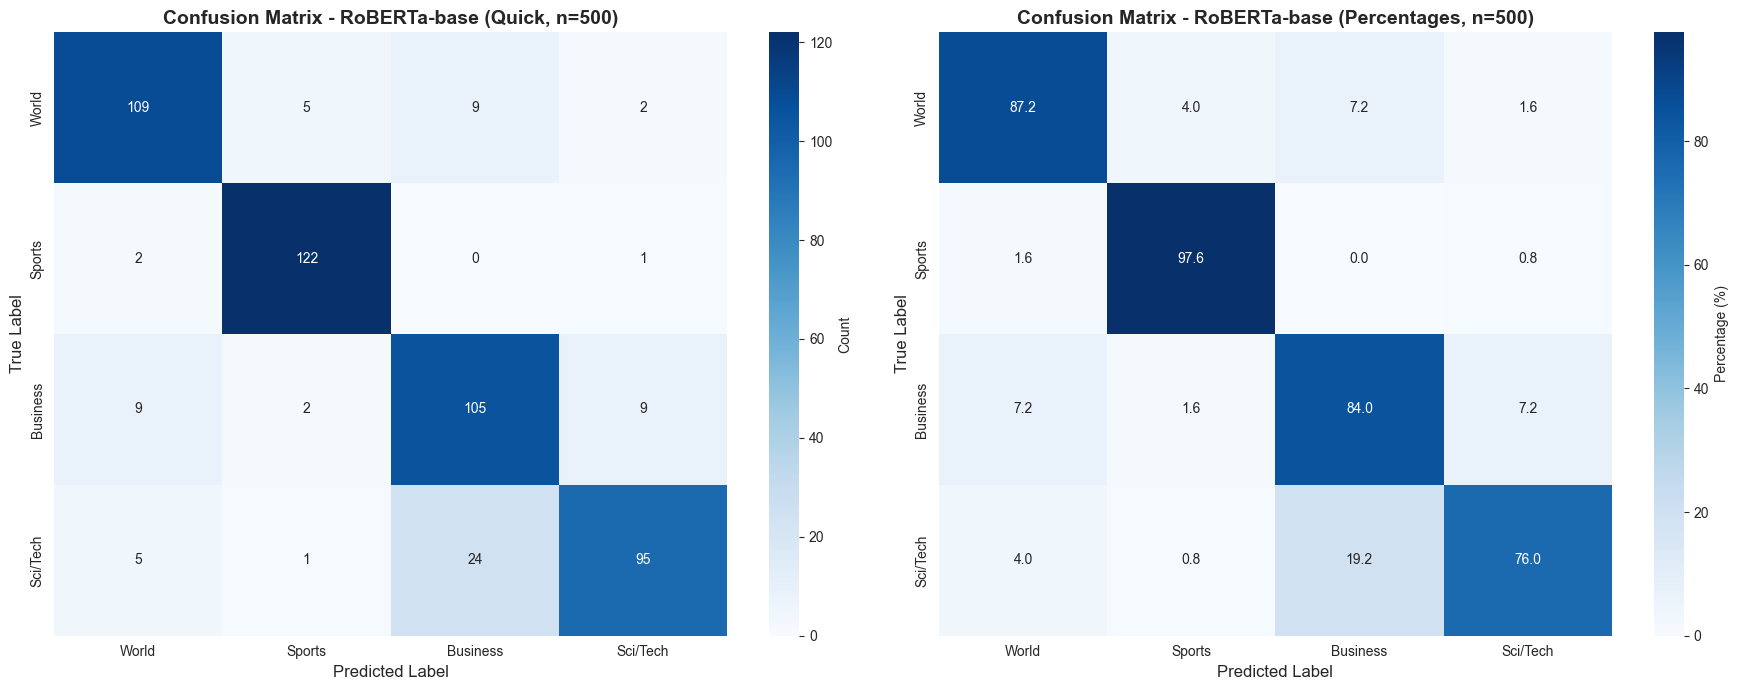

Quick confusion matrix saved to data/roberta_confusion_matrix_quick.png

QUICK CLASSIFICATION REPORT
              precision    recall  f1-score   support

       World       0.87      0.87      0.87       125
      Sports       0.94      0.98      0.96       125
    Business       0.76      0.84      0.80       125
    Sci/Tech       0.89      0.76      0.82       125

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [16]:
# Quick confusion matrix from small subset (fast - ~1-2 minutes)
# Use this if full evaluation is taking too long
QUICK_CM_SIZE = 500  # Use 500 samples for quick visualization

print("=" * 80)
print("QUICK CONFUSION MATRIX GENERATION")
print("=" * 80)
print(f"Generating predictions on {QUICK_CM_SIZE} samples for fast visualization...")
print("This will take ~1-2 minutes\n")

# Create stratified subset
from sklearn.model_selection import train_test_split
test_labels_full = [test_tokenized[i]['label'] for i in range(len(test_tokenized))]
test_indices = np.arange(len(test_tokenized))

_, quick_subset_indices = train_test_split(
    test_indices,
    test_size=QUICK_CM_SIZE,
    stratify=test_labels_full,
    random_state=42
)

test_quick = test_tokenized.select(quick_subset_indices)
print(f"Selected {len(test_quick):,} balanced samples from test set")

# Generate predictions quickly
print("Generating predictions...")
pred_start = time.time()
original_eval_batch_size = trainer.args.per_device_eval_batch_size
trainer.args.per_device_eval_batch_size = 64  # Larger batch for speed
quick_predictions = trainer.predict(test_quick)
trainer.args.per_device_eval_batch_size = original_eval_batch_size
pred_time = time.time() - pred_start

print(f"Predictions completed in {pred_time:.2f} seconds ({pred_time/60:.2f} minutes)\n")

# Extract predictions
y_test_quick = quick_predictions.label_ids
y_pred_quick = np.argmax(quick_predictions.predictions, axis=1)

# Calculate metrics on subset
accuracy_quick = accuracy_score(y_test_quick, y_pred_quick)
f1_quick = f1_score(y_test_quick, y_pred_quick, average='macro')

print(f"{'─'*80}")
print(f"Quick Metrics (on {QUICK_CM_SIZE} samples):")
print(f"  Accuracy: {accuracy_quick:.4f}")
print(f"  Macro F1-Score: {f1_quick:.4f}")
print(f"{'─'*80}\n")

# Create confusion matrix
cm_quick = confusion_matrix(y_test_quick, y_pred_quick)
cm_percent_quick = cm_quick.astype('float') / cm_quick.sum(axis=1)[:, np.newaxis] * 100

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm_quick, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title(f'Confusion Matrix - RoBERTa-base (Quick, n={QUICK_CM_SIZE})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

sns.heatmap(cm_percent_quick, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Percentage (%)'}, ax=axes[1])
axes[1].set_title(f'Confusion Matrix - RoBERTa-base (Percentages, n={QUICK_CM_SIZE})', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
os.makedirs('data', exist_ok=True)
plt.savefig('data/roberta_confusion_matrix_quick.png', dpi=300, bbox_inches='tight')
plt.show()
print("Quick confusion matrix saved to data/roberta_confusion_matrix_quick.png")

print("\n" + "=" * 80)
print("QUICK CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(y_test_quick, y_pred_quick, target_names=class_labels))
print("=" * 80)


## 11. Confusion Matrix


CREATING CONFUSION MATRIX (FAST MODE)
Using subset of 500 samples for faster visualization
Original evaluation used 2,000 samples
Selected 500 balanced samples


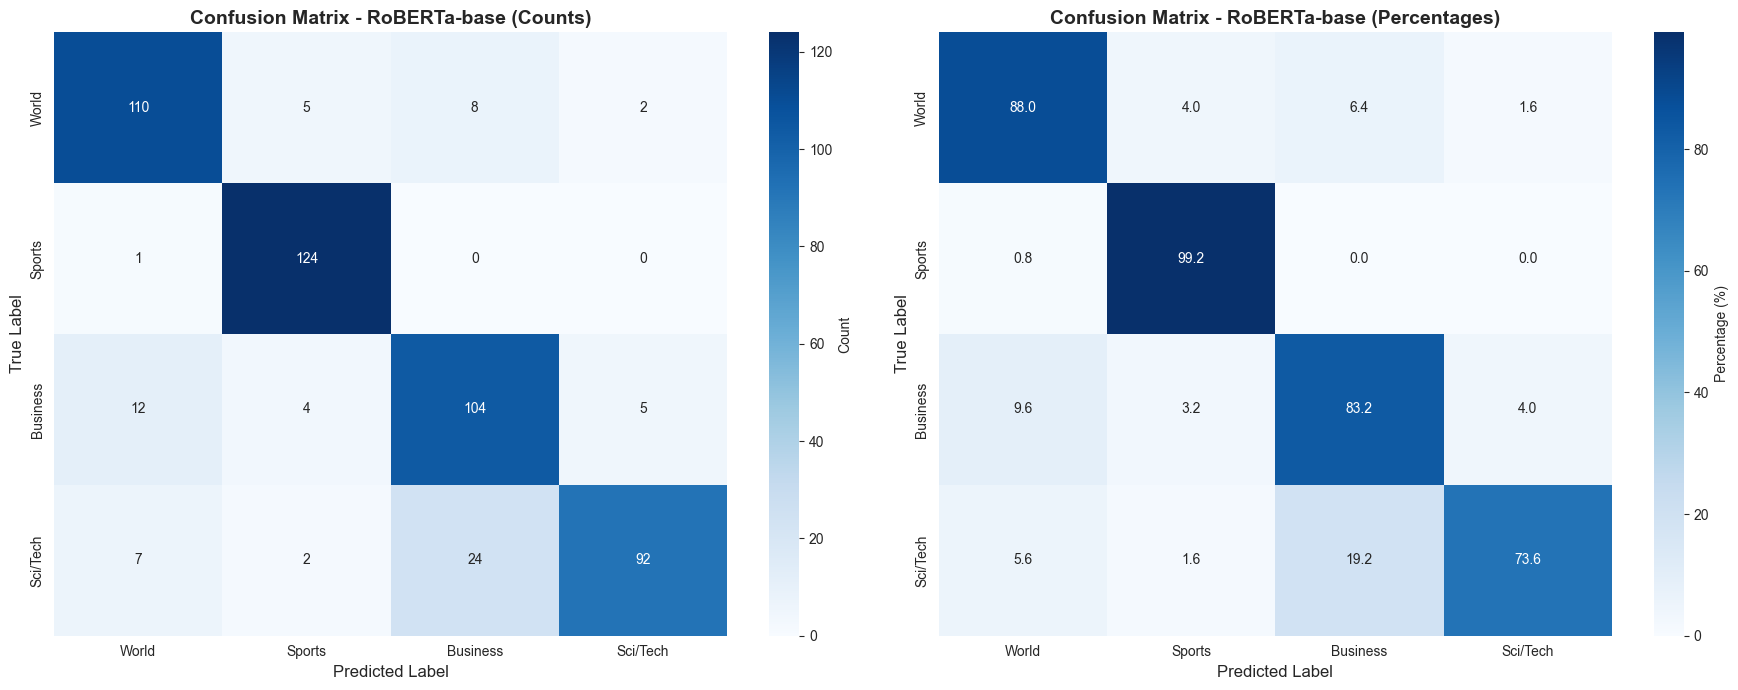

Confusion matrix saved to data/roberta_confusion_matrix.png

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       World       0.85      0.88      0.86       125
      Sports       0.92      0.99      0.95       125
    Business       0.76      0.83      0.80       125
    Sci/Tech       0.93      0.74      0.82       125

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [22]:
# Create confusion matrix
# Option: Use smaller subset for faster confusion matrix generation
USE_FAST_CONFUSION_MATRIX = True  # Set to False to use full evaluation results
CONFUSION_MATRIX_SUBSET_SIZE = 500  # Use 500 samples for quick visualization

if USE_FAST_CONFUSION_MATRIX and 'y_test' in locals() and len(y_test) > CONFUSION_MATRIX_SUBSET_SIZE:
    print("=" * 80)
    print("CREATING CONFUSION MATRIX (FAST MODE)")
    print("=" * 80)
    print(f"Using subset of {CONFUSION_MATRIX_SUBSET_SIZE} samples for faster visualization")
    print(f"Original evaluation used {len(y_test):,} samples")
    
    # Sample subset for confusion matrix
    from sklearn.model_selection import train_test_split
    indices = np.arange(len(y_test))
    _, subset_idx = train_test_split(indices, test_size=CONFUSION_MATRIX_SUBSET_SIZE, 
                                      stratify=y_test, random_state=42)
    y_test_cm = y_test[subset_idx]
    y_pred_cm = y_pred[subset_idx]
    print(f"Selected {len(y_test_cm):,} balanced samples")
else:
    print("=" * 80)
    print("CREATING CONFUSION MATRIX")
    print("=" * 80)
    if 'y_test' in locals():
        print(f"Using {len(y_test):,} samples for confusion matrix")
    else:
        print("Warning: y_test and y_pred not found. Run evaluation cell first.")
        y_test_cm = []
        y_pred_cm = []
    y_test_cm = y_test
    y_pred_cm = y_pred
    print("=" * 80 + "\n")

if len(y_test_cm) > 0:
    cm = confusion_matrix(y_test_cm, y_pred_cm)

    # Calculate percentages for better visualization
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot confusion matrix with both counts and percentages
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Confusion matrix with counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Count'}, ax=axes[0])
    axes[0].set_title('Confusion Matrix - RoBERTa-base (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)

    # Confusion matrix with percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Percentage (%)'}, ax=axes[1])
    axes[1].set_title('Confusion Matrix - RoBERTa-base (Percentages)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)

    plt.tight_layout()
    plt.savefig('data/roberta_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Confusion matrix saved to data/roberta_confusion_matrix.png")

    # Print classification report
    print("\n" + "=" * 80)
    print("CLASSIFICATION REPORT")
    print("=" * 80)
    print(classification_report(y_test_cm, y_pred_cm, target_names=class_labels))
    print("=" * 80)
else:
    print("Cannot create confusion matrix: No predictions available.")
    print("Please run the evaluation cell (Cell 16) first.")


## 12. Compare with Classical Models

Load classical models results and create comparison.


ALL MODELS - COMPARISON
        Model  Accuracy  Macro F1-Score  Log Loss  Training Time (s)  Inference Latency per 1k (s)
      XGBoost  0.880921        0.880733  0.439884        2862.118365                      0.162811
SVM-LinearSVC  0.922763        0.922597       NaN           9.819338                      0.004442
      SVM-RBF  0.864474        0.863662  0.441058        1653.901496                    181.571079
 RoBERTa-base  0.883816        0.883042  0.397079        5911.847447                    493.074890

Combined results saved to data/all_models_results.csv


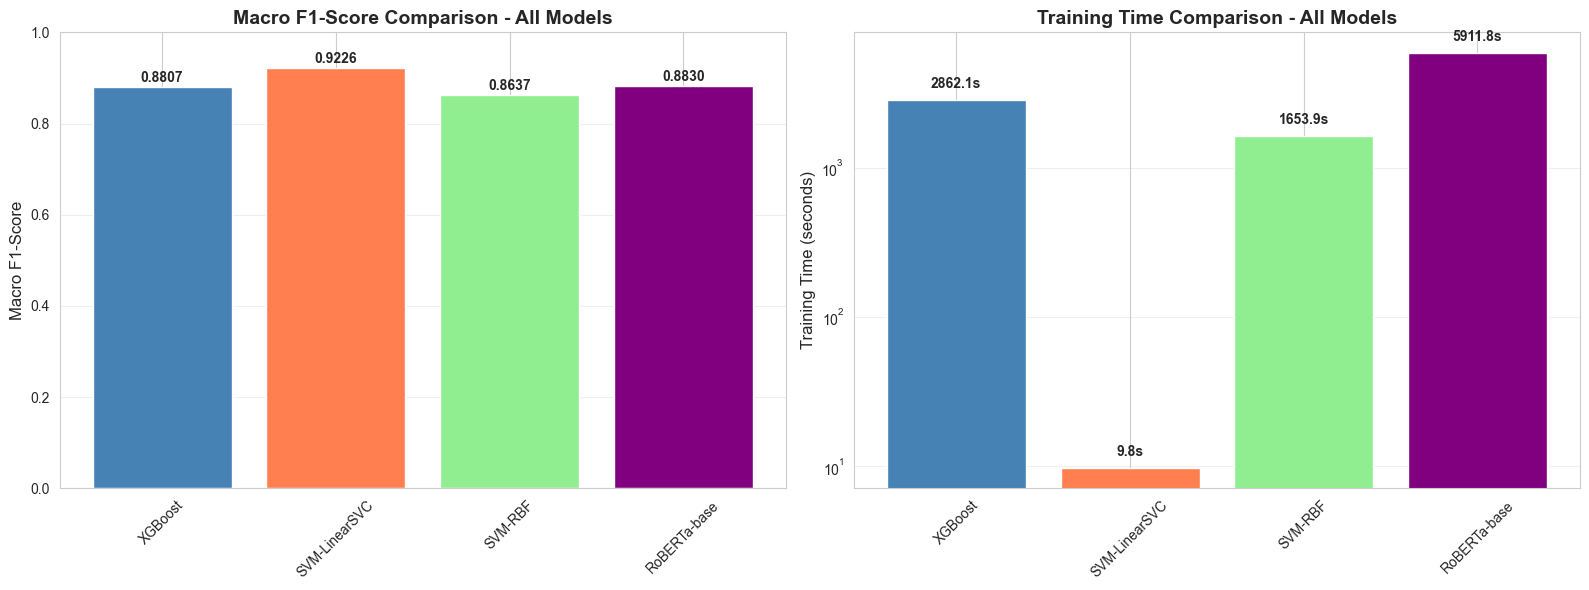

Comparison visualization saved to data/all_models_comparison.png


In [23]:
# Load classical models results if available
classical_results_path = 'data/classical_models_results.csv'

if os.path.exists(classical_results_path):
    classical_df = pd.read_csv(classical_results_path)
    
    # Combine results
    all_results = pd.concat([classical_df, results_df], ignore_index=True)
    
    print("=" * 80)
    print("ALL MODELS - COMPARISON")
    print("=" * 80)
    print(all_results.to_string(index=False))
    print("=" * 80)
    
    # Save combined results
    all_results.to_csv('data/all_models_results.csv', index=False)
    print("\nCombined results saved to data/all_models_results.csv")
    
    # Visualization: F1-Score comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    models = all_results['Model'].values
    f1_scores = all_results['Macro F1-Score'].values
    training_times = all_results['Training Time (s)'].values
    
    # F1-Score comparison
    axes[0].bar(models, f1_scores, color=['steelblue', 'coral', 'lightgreen', 'purple'])
    axes[0].set_title('Macro F1-Score Comparison - All Models', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Macro F1-Score', fontsize=12)
    axes[0].set_ylim([0, 1])
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(f1_scores):
        axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
    
    # Training time comparison
    axes[1].bar(models, training_times, color=['steelblue', 'coral', 'lightgreen', 'purple'])
    axes[1].set_title('Training Time Comparison - All Models', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[1].set_yscale('log')  # Log scale for better visualization
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(training_times):
        axes[1].text(i, v * 1.2, f'{v:.1f}s', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('data/all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Comparison visualization saved to data/all_models_comparison.png")
    
else:
    print("Classical models results not found. Run 02_Classical_Models.ipynb first.")
    print("RoBERTa results saved separately.")
